# Fine-tuning Training on Two-Tower BERT<sub>BASE</sub>

This notebook contains fine-tuning two-tower BERT<sub>BASE</sub> model fitting for recommendation task on users and items reviews.

In [ ]:
import os
import urllib

from google.colab import drive, files
from getpass import getpass

from google.colab import drive

In [ ]:
ROOT = '/content/drive'
GOOGLE_DRIVE_PATH = 'My Drive/Colab Notebooks/recommender/w266-final'
PROJECT_PATH = os.path.join(ROOT, GOOGLE_DRIVE_PATH)

drive.mount(ROOT)

%cd {PROJECT_PATH}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/recommender/w266-final


In [ ]:
import os
import sys
import re
import pandas as pd
import numpy as np
import itertools
import pickle
import random
import tensorflow as tf
import matplotlib.pyplot as plt

from commons.store import PickleStore, NpyStore
from tqdm import tqdm
from IPython.core.display import HTML
from importlib import reload

%load_ext autoreload
%autoreload 2

## 1. Load Pre-filtered Dataset

First, we load the clean pre-processed dataset.

In [ ]:
amazon = False

if amazon:
  input_pkl = '../dataset/25-65_tokens_grouped_Movies_and_TV_v2.pkl'
else:
  input_pkl = '../dataset/25-65_tokens_grouped_yelp.pkl'

pkl_store = PickleStore(input_pkl)

grouped_reviews_df = pkl_store.load(asPandasDF=True, \
                                    columns=['reviewerID', 'asin', 'overall', 'userReviews', 'itemReviews'])
print(len(grouped_reviews_df))
display(HTML(grouped_reviews_df.head(1).to_html()))

Loading ../dataset/25-65_tokens_grouped_yelp.pkl ...
	... 272296 records
Done!!
272296


We select columns that are relevant and covert them to numpy array.

In [ ]:

grouped_reviews = grouped_reviews_df[['reviewerID', 'asin', 'overall', 'userReviews', 'itemReviews']].to_numpy()

We detect hardware and based on the outcome, we define the accelerator strategy.

In [ ]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf

from transformers import BertTokenizer

Here, we load BERT tokenizer using BERT huggingface <img src='https://huggingface.co/front/assets/huggingface_logo.svg' width='20px'> library.

In [ ]:
bert_model_name = 'bert-base-uncased'

MAX_LEN = 64
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
NO_EPOCHS = 30
BUFFER_SIZE = 100

with strategy.scope():
  tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)


## 2. Train, Validation, and Test Split

We split our dataset to train, validation, and test and ensure there is no leak among those.

For the model fitting, we use `MAX_LEN=64` with `BATCH_SIZE=16` and `NO_EPOCHS=30`. We take those considerations such that we can fit our model into a single GPU because of extremely large trainable parameters.

In [ ]:
def train_test_split(reviews, test_percent=0.1):
    """train and test split based on given test percentage"""
    
    samples = len(reviews)

    train_size = int((1 - test_percent) * samples)
    train = reviews[:train_size]
    test = reviews[train_size:]

    return train, test

In [ ]:
np.random.seed(111)
np.random.shuffle(grouped_reviews)

# split for train and test

if amazon:
  test_percent=0.007
else:
  test_percent=0.01

train, test = train_test_split(grouped_reviews, test_percent=test_percent)

In [ ]:
test_revId_uniques = np.unique(test[:,0])
test_asin_uniques = np.unique(test[:,1])

# only pick test reviewerID and asin that are not in train
train = train[np.isin(train[:,0], test_revId_uniques, invert=True, assume_unique=True)]
train = train[np.isin(train[:,1], test_asin_uniques, invert=True, assume_unique=True)]

# split again for train and validation
if amazon:
  val_percent=0.05
else:
  val_percent=0.08
train, val = train_test_split(train, test_percent=val_percent) # , 

val_revId_uniques = np.unique(val[:,0])
val_asin_uniques = np.unique(val[:,1])

# only pick val reviewerID and asin that are not in train
train = train[np.isin(train[:,0], val_revId_uniques, invert=True, assume_unique=True)]
train = train[np.isin(train[:,1], val_asin_uniques, invert=True, assume_unique=True)]


# pick and rearrange to userReviews, itemReviews, overall
train = train[:, [3, 4, 2]]
val = val[:, [3, 4, 2]]
test = test[:, [3, 4, 2]]


In [ ]:
def __tokenize(reviews, tokenizer, max_len):
    return tokenizer(list(reviews), padding='max_length', truncation=True, max_length=max_len, return_tensors='tf') 

def create_tensor_dataset(samples, tokenizer, max_len=128):
  """generate dataset to tensorflow dataset format for two-tower network"""

  def gen():
    for i, reviews in enumerate(samples):
      # tokenize each group of users and items reviews
      user_tokens = __tokenize(reviews[0], tokenizer, max_len)
      item_tokens = __tokenize(reviews[1], tokenizer, max_len)

      yield ({'user_input_ids': [user_tokens.data['input_ids']],
              'user_token_type_ids': [user_tokens.data['token_type_ids']], 
              'user_attention_masks': [user_tokens.data['attention_mask']],
              'item_input_ids': [item_tokens.data['input_ids']],
              'item_token_type_ids': [item_tokens.data['token_type_ids']],
              'item_attention_masks': [item_tokens.data['attention_mask']]}, 
             {'label': [reviews[2]]})
  
  # generator with output signature
  dataset = tf.data.Dataset.from_generator(
      gen, 
      output_signature=({'user_input_ids': tf.TensorSpec(shape=(None, None, max_len), dtype=tf.int32),
                        'user_token_type_ids': tf.TensorSpec(shape=(None, None, max_len), dtype=tf.int32),
                        'user_attention_masks': tf.TensorSpec(shape=(None, None, max_len), dtype=tf.int32),
                        'item_input_ids': tf.TensorSpec(shape=(None, None, max_len), dtype=tf.int32),
                        'item_token_type_ids': tf.TensorSpec(shape=(None, None, max_len), dtype=tf.int32),
                        'item_attention_masks': tf.TensorSpec(shape=(None, None, max_len), dtype=tf.int32)},
                        {'label':tf.TensorSpec(shape=(None), dtype=tf.float32)})
  )

  return dataset


Because of the variant number of reviews on each grouped of users and items reviews, only tensorflow Dataset API with `from_generator` can support to format our dataset and be fitted to our two-tower BERT<sub>BASE</sub> model. The drawback is the training cannot be parallelized to multiple accelerators because the generator itself is a python function, and therefore tensorflow is unable to serialize that function to multiple accelerators strategy. This method, however, can support for streaming large dataset and generate the dataset by batches to fit into the model.

In [ ]:
train_dataset = create_tensor_dataset(train, tokenizer=tokenizer, 
                                      max_len=MAX_LEN)

val_dataset = create_tensor_dataset(val, tokenizer=tokenizer, 
                                    max_len=MAX_LEN)

test_dataset = create_tensor_dataset(test, tokenizer=tokenizer, 
                                     max_len=MAX_LEN)


## 3. Model Definition and Callbacks

We use Two-tower network for our model where each tower learns latent feature representation of user and item reviews respectively. We apply layer normalization and dropout of $0.2$ for regularization to prevent overfitting.

BERT huggingface <img src='https://huggingface.co/front/assets/huggingface_logo.svg' width='20px'> library is used for our BERT<sub>BASE</sub> model.

In [ ]:
from transformers import TFBertModel, BertConfig

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Layer, Flatten, Concatenate, Dense, Add, Dot, Dropout, GlobalAveragePooling2D, LayerNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

%load_ext tensorboard

class BertLayer(Layer):

  def __init__(self, config, max_len):
    super().__init__()

    self.config = config
    self.max_len = max_len
    self.bert = TFBertModel.from_pretrained(bert_model_name, config=self.config)

  def call(self, input):
    return tf.map_fn(
      lambda x: self.bert(x).last_hidden_state,
      dtype=tf.int32,
      elems=input,
      fn_output_signature=tf.TensorSpec(shape=(None, self.max_len, 768), dtype=tf.float32)
    )

class RecommenderClassifier():
  def __init__(self, bert_config, max_len=128, hidden_dim=32, rate=0.1):

      self.bert_config = bert_config
      self.max_len = max_len
      self.hidden_dim = hidden_dim

      self.layernorm = LayerNormalization(epsilon=1e-6)

      self.user_ids, self.user_token_types, self.user_masks, self.user_tower = self.__create_tower('user')
      self.item_ids, self.item_token_types, self.item_masks, self.item_tower = self.__create_tower('item')
      self.joined = Concatenate()([self.user_tower, self.item_tower])
      self.dropout = Dropout(rate)(self.joined)
      self.out_1 = Dense(1)(self.dropout)


  def __create_tower(self, name):
    input_ids_layer = Input(shape=(None, self.max_len), name=f'{name}_input_ids', dtype=tf.int32)
    token_type_ids_layer = Input(shape=(None, self.max_len), name=f'{name}_token_type_ids', dtype=tf.int32)
    attention_mask_layer = Input(shape=(None, self.max_len), name=f'{name}_attention_masks', dtype=tf.int32)

    bert_layer = BertLayer(self.bert_config, self.max_len)
    input_embedding = bert_layer([input_ids_layer, attention_mask_layer, token_type_ids_layer])
    mean_embedding = GlobalAveragePooling2D(name=f'{name}_mean')(input_embedding)

    tower = Dense(self.hidden_dim, activation="relu", name=f'{name}_dense')(mean_embedding)
    tower = self.layernorm(tower)

    return input_ids_layer, token_type_ids_layer, attention_mask_layer, tower
  

  def build_model(self):
    dotproduct = Dot(axes=1)([self.user_tower, self.item_tower])
    output = Add(name='label')([self.out_1, dotproduct])
    
    model = Model(inputs=[self.user_ids, self.user_token_types, self.user_masks, 
                          self.item_ids, self.item_token_types, self.item_masks], 
                  outputs=[output])

    return model


In [ ]:
config = BertConfig()
config.output_hidden_states = True # set to True to obtain hidden states

with strategy.scope():
  loss_fn = tf.keras.losses.MeanSquaredError()
  adam = tf.keras.optimizers.Adam(learning_rate=0.00002) # 0.000002
  mse_metrics = tf.keras.metrics.MeanSquaredError()

  classifier = RecommenderClassifier(config, max_len=MAX_LEN, rate=0.2)
  model = classifier.build_model()

  model.compile(optimizer=adam, loss=loss_fn, metrics=[mse_metrics])
  model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Instructions for updating:
Use fn_output_signature instead
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence th

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input_ids (InputLayer)     [(None, None, 64)]   0                                            
__________________________________________________________________________________________________
user_attention_masks (InputLaye [(None, None, 64)]   0                                            
__________________________________________________________________________________________________
user_token_type_ids (InputLayer [(None, None, 64)]   0                                            
__________________________________________________________________________________________________
item_input_ids (InputLayer)     [(None, None, 64)]   0                                            
______________________________________________________________________________________________

In [ ]:
# Tensorboard and checpoint callbacks

def tensorboard_checkpoint_callbacks(name):

  if amazon:
    tensorboard_dir = ''.join(['./logs/tensorboard/', name])
  else:
    tensorboard_dir = ''.join(['./yelp/logs/tensorboard/', name])

  if not os.path.exists(tensorboard_dir):
      os.makedirs(tensorboard_dir)

  version = 1
  dirs = [d for d in os.listdir(tensorboard_dir) if not d.startswith('.')]

  if (len(dirs) > 0):
      versions = np.asarray(list(map(lambda v: int(v[1:]), dirs)))
      version = versions[versions.argsort()[::-1][0]]
      version += 1

  tensorboard_version_dir = os.path.join(tensorboard_dir, ''.join(['v', str(version)]))
  print(tensorboard_version_dir)

  tensorboard_callback = TensorBoard(log_dir=tensorboard_version_dir, histogram_freq=1)

  if amazon:
    checkpoint_dir = './logs/chkpoint'
  else:
    checkpoint_dir = './yelp/logs/chkpoint'

  checkpoint_name_dir = os.path.join(checkpoint_dir, name, ''.join(['v', str(version)]))
  if not os.path.exists(checkpoint_name_dir):
      os.makedirs(checkpoint_name_dir)

  checkpoint_file = os.path.join(checkpoint_name_dir, 'weights.best.hdf5')

  print(checkpoint_file)
  checkpoint_callback = ModelCheckpoint(checkpoint_file, monitor='val_loss', verbose=0, save_best_only=True, 
                                        save_weights_only=True)
  
  return tensorboard_callback, checkpoint_callback, version



In [ ]:
name = 'finetuned'
tensorboard_callback, checkpoint_callback, version = tensorboard_checkpoint_callbacks(name)
lr_onplateau_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

./yelp/logs/tensorboard/finetuned/v1
./yelp/logs/chkpoint/finetuned/v1/weights.best.hdf5


Learning rate per epoch:


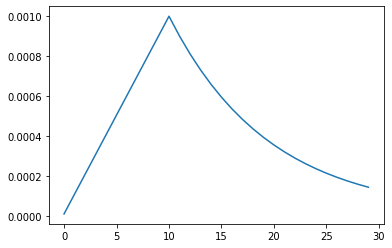

In [ ]:
# Early stopping callback
earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=10)

# Learning rate scheduler callback
# optimizer (with 1-cycle-policy)
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.001 * strategy.num_replicas_in_sync
rampup_epochs = 10
sustain_epochs = 0
exp_decay = .9

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(NO_EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

## 4. Model Fitting

We train our recommendation classifier model with MSE loss function and Adam optimizer with initial learning rate of $2e^{-5}$. We also apply tensorboard, checkpoint and learning rate reduce on plateau with factor of $0.2$ and patience of $5$ as callbacks.

We experimented with one-cycle-policy learning rate scheduler, however it appears that learning rate reduce on plateau performs better on fine-tuning approach.

In [ ]:
%%time
train_size = len(train)
train_steps_per_epoch = train_size // BATCH_SIZE

val_size = len(val)
val_steps_per_epoch = val_size // BATCH_SIZE

history = model.fit(train_dataset.shuffle(BUFFER_SIZE), 
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[lr_onplateau_callback, tensorboard_callback, checkpoint_callback], #  lr_callback , earlystop_callback
                    epochs=NO_EPOCHS)

Epoch 1/30
1462/1462 [==============================] - 914s 541ms/step - loss: 6.9579 - mean_squared_error: 6.9579 - val_loss: 1.5453 - val_mean_squared_error: 1.5453
Epoch 2/30
1462/1462 [==============================] - 772s 528ms/step - loss: 1.8724 - mean_squared_error: 1.8724 - val_loss: 1.3124 - val_mean_squared_error: 1.3124
Epoch 3/30
1462/1462 [==============================] - 773s 529ms/step - loss: 1.8499 - mean_squared_error: 1.8499 - val_loss: 1.1583 - val_mean_squared_error: 1.1583
Epoch 4/30
1462/1462 [==============================] - 768s 525ms/step - loss: 1.6981 - mean_squared_error: 1.6981 - val_loss: 1.1989 - val_mean_squared_error: 1.1989
Epoch 5/30
1462/1462 [==============================] - 762s 521ms/step - loss: 1.6965 - mean_squared_error: 1.6965 - val_loss: 1.1918 - val_mean_squared_error: 1.1918
Epoch 6/30
1462/1462 [==============================] - 768s 526ms/step - loss: 1.7010 - mean_squared_error: 1.7010 - val_loss: 1.1635 - val_mean_squared_error:

## 5. Model Evaluation

We evaluate our model using hold-out test dataset to obtain the final MSE. Subsequently, we save our model's weights only on those that have better performance.

In [ ]:
mse, _ = model.evaluate(test_dataset)
print(f'Test MSE: {mse}')

2723/2723 [==============================] - 558s 205ms/step - loss: 1.0797 - mean_squared_error: 1.0797
Test MSE: 1.0797028541564941


In [ ]:
model_dir = './model'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if amazon:
  model_file = ''.join([model_dir, '/recommender_', name, '_64_v', str(version), '.h5'])
else:
  model_file = ''.join([model_dir, '/yelp_recommender_', name, '_64_v', str(version), '.h5'])

model.save_weights(model_file, save_format='h5')

In [ ]:
model_file

'./model/yelp_recommender_finetuned_64_v1.h5'